# EOLES_elecRES in Julia

[EOLES_elecRES](https://github.com/BehrangShirizadeh/EOLES_elecRES) ported to Julia, with the [JuMP]() package.

Precisely: EOLES_elecRES.gms

PH, Feb 2021

In [1]:
using CSV, DataFrames, PyPlot

## Model data

### Sets

#### hours and months

sets `h /0*8759/`

         first(h)        'first hour'
         last(h)         'last hour'
         
         first(h) = ord(h)=1;
last(h) = ord(h)=card(h);

alias(h,hh);

In [2]:
h = 0:8759

0:8759

In [3]:
first_h = h .== h[1] # BitArray, with first element true
last_h = h .== h[end]; # BitArray, with last element true

In [4]:
m = [:jan, :feb, :mar, :apr, :may, :jun, :jul, :aug, :sep, :oct, :nov, :dec]

12-element Array{Symbol,1}:
 :jan
 :feb
 :mar
 :apr
 :may
 :jun
 :jul
 :aug
 :sep
 :oct
 :nov
 :dec

#### technology sets

All technologies

In [5]:
tec = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas, :phs, :battery, :methanation] 

10-element Array{Symbol,1}:
 :offshore
 :onshore
 :pv
 :river
 :lake
 :biogas
 :gas
 :phs
 :battery
 :methanation

Subsets of `tec`

In [6]:
# power plants
gen = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas]
# variable tecs
vre = [:offshore, :onshore, :pv]
# non-combustible generation
ncomb = [:offshore, :onshore, :pv, :river, :lake, :phs, :battery]
# combustible generation techs
comb = [:biogas, :methanation] # Q: is it a bug. Should it be biogas and gas?
# storage technologies
str = [:phs, :battery, :methanation]
# technologies for upward FRR
frr = [:lake, :phs, :battery, :gas];

Check that subsets are indeed subsets (i.e. performing the automatic [domain checking](https://www.gams.com/latest/docs/UG_SetDefinition.html#UG_SetDefinition_DomainChecking) of GAMS)

In [7]:
for tec_subset in [gen, vre, ncomb, comb, str, frr]
    @assert issubset(tec_subset, tec) "should be a subset of tec!"
end

### Parameters

Original GAMS definition for months:
```
parameter month(h)  /0*743 1, 744*1439 2, 1440*2183 3, 2184*2903 4
                    2904*3647 5, 3648*4367 6, 4368*5111 7, 5112*5855 8
                    5856*6575 9, 6576*7319 10, 7320*8039 11, 8040*8759 12/
```

observe that February has 29 days, which is compensated by December having only 30:

In [8]:
(1439 - 744 +1)/24, (8759 - 8040 +1)/24

(29.0, 30.0)

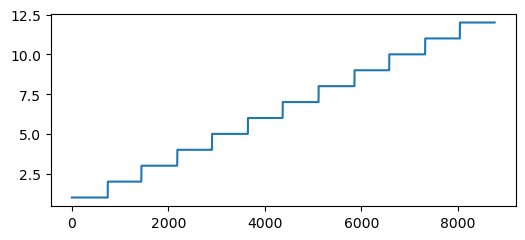

In [9]:
month = [
     repeat([1], 31*24);  repeat([2], 29*24);  repeat([3], 31*24);  repeat([4], 30*24);
     repeat([5], 31*24);  repeat([6], 30*24);  repeat([7], 31*24);  repeat([8], 31*24);
     repeat([9], 30*24); repeat([10], 31*24); repeat([11], 30*24); repeat([12], 30*24)
]

figure(figsize=(6,2.5))
plot(h, month);

parameter `load_factor(vre,h)` 'Production profiles of VRE'

from file `inputs/vre_profiles2006.csv`

In [135]:
"""
    readdelim(source, dims...; default_value=0.)

Read the CSV file `source` formatted as for the GAMS' `\$onDelim`/`\$offDelim` instructions
(i.e. a long, database-like format).
The vectors of each dimension of the output are specified with `dims`.

Remark: Strings are lowercased and converted to Symbols
"""
function readdelim(source, dims...; default_value=0.)
    print("reading $source...")
    # create reverse maps from value  to index for each dim vector
    ndim = length(dims)
    dim_maps = []
    for dim in dims
        dim_map = Dict((v,i) for (i,v) in enumerate(dim))
        push!(dim_maps, dim_map)
    end
    
    # load datafile
    df = DataFrame(CSV.File(source, header=false))
    ncol = size(df,2)
    @assert ncol == (ndim+1) "$(ndim+1) columns exected in $source, got $(ncol)"
    
    # Create array and fill with data
    a = zeros((length(dim) for dim in dims)...)
    fill!(a, default_value)
    
    to_symb(a) = if (typeof(a) == String) Symbol(lowercase(a)) else a end
    
    for row in eachrow(df)
        if ndim == 1
            i = dim_maps[1][to_symb(row[1])]
            a[i] = row[2]
        elseif ndim == 2
            i = dim_maps[1][to_symb(row[1])]
            j = dim_maps[2][to_symb(row[2])]
            a[i,j] = row[3]
        else
            throw(ArgumentError("only 2 dims supported, got $(ndim)!"))
        end
    end
    return a
end

readdelim

In [126]:
load_factor = readdelim("inputs/vre_profiles2006.csv", vre, h; default_value=0.)

reading inputs/vre_profiles2006.csv...

3×8760 Array{Float64,2}:
 0.865143  0.88     0.88      0.873429  …  0.990286  0.991     0.988143
 0.511702  0.52791  0.537973  0.541571     0.826158  0.825222  0.818481
 0.0       0.0      0.0       0.0          0.0       0.0       0.0

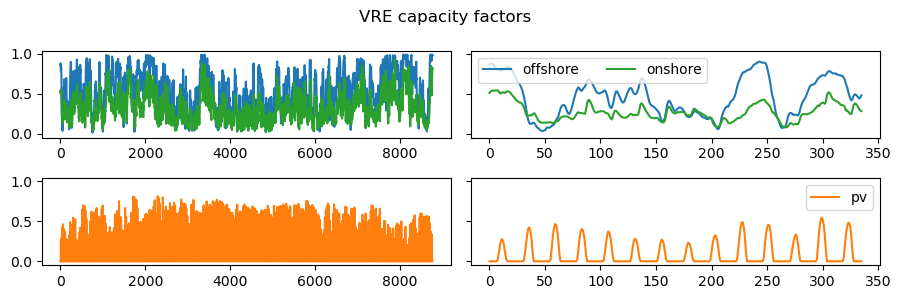

In [115]:
z = 1:24*14 # zoom
fig, ax = subplots(2,2, figsize=(9, 3), sharey=true)

# Wind
ax[1,1].plot(h, load_factor[1,:], label=vre[1])
ax[1,1].plot(h, load_factor[2,:], "C2", label=vre[2])
ax[1,2].plot(h[z], load_factor[1,z], label=vre[1])
ax[1,2].plot(h[z], load_factor[2,z], "C2", label=vre[2])
ax[1,2].legend(ncol=2)

# PV
ax[2,1].plot(h, load_factor[3,:], "C1", label=vre[3])
ax[2,2].plot(h[z], load_factor[3,z], "C1", label=vre[3])
ax[2,2].legend()


fig.suptitle("VRE capacity factors")
fig.tight_layout();

Parameter `demand(h)` 'demand profile in each hour in GW'

from file `inputs/demand2050_ademe.csv`

In [129]:
demand = readdelim("inputs/demand2050_ademe.csv", h);

reading inputs/demand2050_ademe.csv...

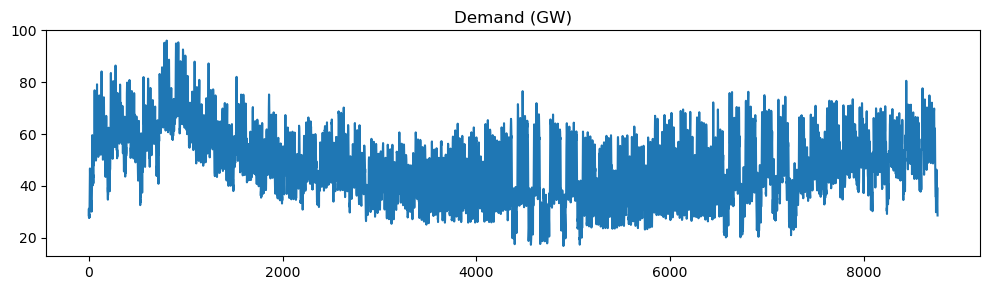

In [130]:
figure(figsize=(10, 3))
plot(h, demand)
title("Demand (GW)")
tight_layout()

Parameter `lake_inflows(m)` 'monthly lake inflows in GWh'

from `inputs/lake_inflows.csv`

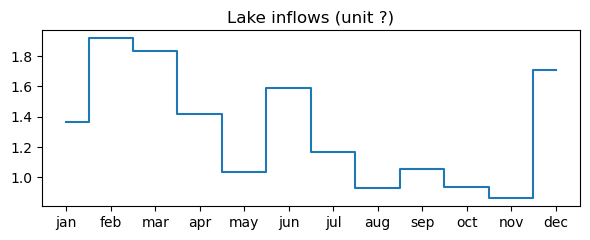

reading inputs/lake_inflows.csv...

In [132]:
lake_inflows = readdelim("inputs/lake_inflows.csv", m)

figure(figsize=(6,2.5))
step(m, lake_inflows, where="mid")
title("Lake inflows (unit ?)")
tight_layout()

parameter `gene_river(h)` 'hourly run of river power generation in GWh'

from `inputs/run_of_river.csv`

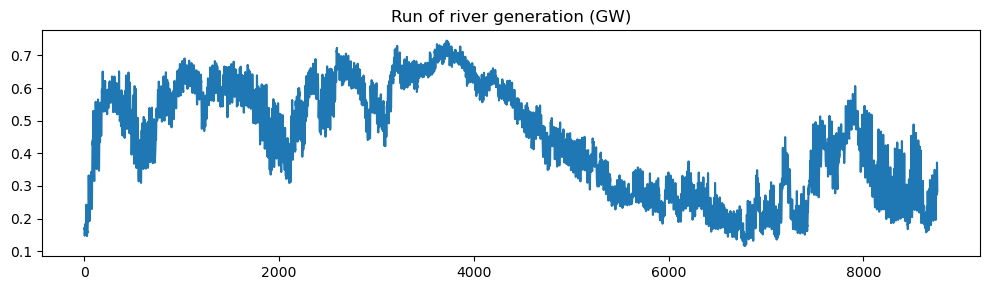

reading inputs/run_of_river.csv...

In [133]:
gene_river = readdelim("inputs/run_of_river.csv", h)

figure(figsize=(10, 3))
plot(h, gene_river)
title("Run of river generation (GW)")
tight_layout()

parameter `epsilon(vre)` 'additional FRR requirement for variable renewable energies because of forecast errors'

from `inputs/reserve_requirements.csv`

In [136]:
epsilon = readdelim("inputs/reserve_requirements.csv", vre)

reading inputs/reserve_requirements.csv...

3-element Array{Float64,1}:
 0.027
 0.027
 0.038

parameter `capa_ex(tec)` 'existing capacities of the technologies by December 2017 in GW'

from `inputs/existing_capas.csv`

Remark: gas is missing from file, but default value is 0. in `readdelim`

In [147]:
capa_ex = readdelim("inputs/existing_capas.csv", tec)
[tec capa_ex]

reading inputs/existing_capas.csv...

10×2 Array{Any,2}:
 :offshore      0.0
 :onshore       0.0
 :pv            0.0
 :river         7.5
 :lake         12.855
 :biogas        0.0
 :gas           0.0
 :phs           4.94
 :battery       0.0
 :methanation   0.0

parameter `capa_max(tec)` 'maximum capacities of the technologies in GW'

from `inputs/max_capas.csv`

again "gas" is missing from the file, but perhaps the **default value of 0.0 will created a problem!**

In [146]:
capa_max = readdelim("inputs/max_capas.csv", tec)
[tec capa_max]

reading inputs/max_capas.csv...

10×2 Array{Any,2}:
 :offshore      20.0
 :onshore      120.0
 :pv           218.0
 :river          7.5
 :lake          13.0
 :biogas       100.0
 :gas            0.0
 :phs            9.3
 :battery      100.0
 :methanation  100.0

parameter `capex(tec)` 'annualized power capex cost in M€/GW/year'

from `inputs/annuities.csv`

In [148]:
capex = readdelim("inputs/annuities.csv", tec)
[tec capex]

reading inputs/annuities.csv...

10×2 Array{Any,2}:
 :offshore     144.368
 :onshore       77.6621
 :pv            30.0052
 :river        143.909
 :lake         110.233
 :biogas         0.0
 :gas           33.7653
 :phs           24.6938
 :battery       14.8876
 :methanation    0.0

*TO BE CONTINUED*

In [ ]:
parameter capex_en(str) 'annualized energy capex cost of storage technologies in M€/GWh/year'
/
$ondelim
$include  inputs/str_annuities.csv
$offdelim
/ ;

In [ ]:
parameter fOM(tec) 'annualized fixed operation and maintenance costs M€/GW/year'
/
$ondelim
$include  inputs/fO&M.csv
$offdelim
/ ;

In [ ]:
Parameter vOM(tec) 'Variable operation and maintenance costs in M€/GWh'
/
$ondelim
$include  inputs/vO&M.csv
$offdelim
/ ;

```gams
parameter s_capex(str) 'charging related annuity of storage in M€/GW/year' /PHS 0, battery 0, methanation 84.16086/;
parameter s_opex(str)    'charging related fOM of storage in M€/GW/year'   /PHS 0, battery 0, methanation 59.25/;
parameter eta_in(str) 'charging efifciency of storage technologies' /PHS 0.95, battery 0.9, methanation 0.59/;
parameter eta_out(str) 'discharging efficiency of storage technolgoies' /PHS 0.9, battery 0.95, methanation 0.45/;
scalar pump_capa 'pumping capacity in GW' /9.3/;
scalar max_phs 'maximum volume of energy can be stored in PHS reservoir in TWh' /0.18/;
scalar max_biogas 'maxium energy can be generated by biogas in TWh' /15/;
scalar load_uncertainty 'uncertainty coefficient for hourly demand' /0.01/;
scalar delta 'load variation factor'     /0.1/;
parameter fixed_costs(tec) 'yearly fixed cost of each tec in M€/GW/year' ;
fixed_costs(tec) = capex(tec) + fOM(tec);
```

## Model

### Variables

```
variables        GENE(tec,h)     'hourly energy generation in TWh'
                 CAPA(tec)       'overal yearly installed capacity in GW'
                 STORAGE(str,h)  'hourly electricity input of battery storage GW'
                 S(str)          'charging power capacity of each storage technology'
                 STORED(str,h)   'energy stored in each storage technology in GWh'
                 CAPACITY(str)   'energy volume of storage technologies in GWh'
                 RSV(frr,h)      'required upward frequency restoration reserve in GW'
                 COST            'final investment cost in b€'

positive variables GENE(tec,h),CAPA(tec),STORAGE(str,h), S(str),STORED(str,h),CAPACITY(str),RSV(frr,h);
```

### Equations

```
equations        gene_vre        'variables renewable profiles generation'
                 gene_capa       'capacity and genration relation for technologies'
                 combustion      'the relationship of combustible technologies'
                 capa_frr        'capacity needed for the secondary reserve requirements'
                 storing         'the definition of stored energy in the storage options'
                 storage_const   'storage in the first hour is equal to the storage in the last hour'
                 lake_res        'constraint on water for lake reservoirs'
                 stored_cap      'maximum energy that is stored in storage units'
                 storage_capa1   'the capacity with hourly charging relationship of storage'
                 storage_capa2   'storage power limit'
                 biogas_const    'maximum energy can be produced by biogas'
                 reserves        'FRR requirement'
                 adequacy        'supply/demand relation'
                 obj             'the final objective function which is COST';

gene_vre(vre,h)..                GENE(vre,h)             =e=     CAPA(vre)*load_factor(vre,h);
gene_capa(tec,h)..               CAPA(tec)               =g=     GENE(tec,h);
combustion(h)..                  GENE('gas',h)           =e=     sum(comb,GENE(comb,h));
capa_frr(frr,h)..                CAPA(frr)               =g=     GENE(frr,h) + RSV(frr,h);
storing(h,h+1,str)..             STORED(str,h+1)         =e=     STORED(str,h) + STORAGE(str,h)*eta_in(str) - GENE(str,h)/eta_out(str);
storage_const(str,first,last)..  STORED(str,first)       =e=     STORED(str,last)+STORAGE(str,last)*eta_in(str)-GENE(str,last)/eta_out(str);
lake_res(m)..                    lake_inflows(m)         =g=     sum(h$(month(h) = ord(m)),GENE('lake',h))/1000;
stored_cap(str,h)..              STORED(str,h)           =l=     CAPACITY(str);
storage_capa1(str,h)..           S(str)                  =g=     STORAGE(str,h);
storage_capa2(str)..             S(str)                  =l=     CAPA(str);
biogas_const..                   sum(h,GENE('biogas',h)) =l=     max_biogas*1000;
reserves(h)..                    sum(frr, RSV(frr,h))    =e=     sum(vre,epsilon(vre)*CAPA(vre))+ demand(h)*load_uncertainty*(1+delta);
adequacy(h)..                    sum(ncomb,GENE(ncomb,h))+GENE('gas',h)    =g=     demand(h)+sum(str,STORAGE(str,h)) ;
obj..                            COST                    =e=     (sum(tec,(CAPA(tec)-capa_ex(tec))*capex(tec))+ sum(str,CAPACITY(str)*capex_en(str))+sum(tec,(CAPA(tec)*fOM(tec)))+ sum(str,S(str)*(s_capex(str)+s_opex(str))) + sum((tec,h),GENE(tec,h)*vOM(tec)))/1000;
```